# Modeling the Effect of Sex and Race on Risk of Violence Using COMPAS score data.

This tutorial is based on an R version of this tutorial, which can be found [here](http://htmlpreview.github.io/?https://github.com/picoral/pit-un-2022/blob/master/R%20tutorials/compas-case-study.html)

The data that we'll be using for this tutorial is from [this work by ProPublica](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) which aimed to assess a popular commercial system COMPAS, which is a criminal defendant risk-assessment tool, for bias against any individual groups. They evaluated the Risk of Recidivism algorithm, in this tutorial, we're going to evaluate the Risk of Violence algorithm.

Imports:

In [1]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
import statsmodels.api as sm

First, let's read the data into a Pandas DataFrame:

In [2]:
compas_data = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv")
compas_data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


To determine the number of unique persons there are in this data (we can see above that there are multiple rows - i.e., *observations* - per person), we can take the length of the set of the `Person_ID` column (alternatively, we could also use the unique method demonstrated below)

In [3]:
len(set(compas_data.Person_ID))

18610

This tells us there are 18,610 unique (or distinct) IDs in the data.

The data comes from ProPublica who released the initial study on this data. They state that "Each pre-trial defendant received at least three COMPAS scores: `Risk of Recidivism`, `Risk of Violence`, and `Risk of Failure to Appear`. 

Because we're interested in modeling recidivism by race, what races are represented in this data?

In [4]:
compas_data.Ethnic_Code_Text.unique()

array(['Caucasian', 'African-American', 'Hispanic', 'Other', 'Asian',
       'African-Am', 'Native American', 'Oriental', 'Arabic'],
      dtype=object)

The names used to represent the races/ethnic groups are both messy and not entirely politically correct. We'll create a new column in our dataframe called `race_ethnicity` to contain our new attributes, to make a few adjustments that will, at least, partially improve the labels.

In [5]:
compas_data["race_ethnicity"] = compas_data.Ethnic_Code_Text.replace(
    to_replace = {"Caucasian": "White", 
                "African-Am": "African-American",
                "Oriental":"Asian"})
print(compas_data.Ethnic_Code_Text.unique(),
    compas_data.race_ethnicity.unique())

['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic'] ['White' 'African-American' 'Hispanic' 'Other' 'Asian' 'Native American'
 'Arabic']


For the purposes of this tutorial, we'll use only the `Risk of Violence` decile score. The goal is to answer the question: what is the effect of sex and race on risk of violence decile scores?

Let's filter the data by Risk of Violence in the DisplayText column, and then extract only the columns we are interested in.

In [6]:
violence_risk = compas_data[compas_data.DisplayText == "Risk of Violence"]
violence_risk.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,race_ethnicity
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,White
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,White
6,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,08/25/94,...,High,7,Risk of Violence,-1.20,8,High,New,1,0,African-American
9,50850,57176,51958,PRETRIAL,Debe,Mikerlie,George,Female,African-American,10/09/94,...,Medium,7,Risk of Violence,-1.29,7,Medium,New,1,0,African-American
12,50839,57162,51945,PRETRIAL,McLaurin,Stephanie,Nicole,Female,African-American,06/29/85,...,Low,7,Risk of Violence,-2.90,2,Low,New,1,0,African-American


We should store this data for future use:

In [7]:
violence_risk.to_csv("data/risk_of_violence.csv")

Now, back to modeling. We know that we only have data on risk of violence from the COMPAS dataset and we want to determine the effect of sex and race on the risk of violence scores. We can do this using statsmodel's OLS function with the `.from_formula` method, which will allow us to establish the relationships between variables of interest ourselves. This is similar to the `lm` function in `R`. `sm.OLS` will take care of one-hot encoding the data in order to make predictions. We'll then group the data by race and take the average of the predicted `DecileScore`s to answer the question "what is the mean score across all races?"

In [8]:
# fit model and get average predictions by race
formula = "DecileScore ~ race_ethnicity + Sex_Code_Text"
model2 = sm.OLS.from_formula(formula = formula,
                            data = violence_risk)
results = model2.fit()
predict_results = results.get_prediction(row_labels = violence_risk.race_ethnicity.values)
result_frame = predict_results.summary_frame().groupby(level=0).mean()

In [9]:
# make race_ethnicity a col in result_frame and sort in descending order
result_frame.reset_index(inplace = True)
result_frame = result_frame.rename(columns = {'index':'race_ethnicity'})
result_frame.sort_values(by = "mean", ascending= False, inplace = True)
result_frame

,race_ethnicity,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,African-American,4.183863,0.028432,4.128135,4.239592,-0.333110,8.700837
4,Native American,3.671233,0.270263,3.141495,4.200971,-0.876343,8.218809
1,Arabic,2.880000,0.460924,1.976552,3.783448,-1.726087,7.486087
6,White,2.602810,0.031548,2.540972,2.664647,-1.914240,7.119859
5,Other,2.594907,0.079760,2.438571,2.751244,-1.924416,7.114231
3,Hispanic,2.570350,0.045292,2.481574,2.659126,-1.947145,7.087845
2,Asian,2.099174,0.210025,1.687508,2.510839,-2.436165,6.634512


There are multiple ways to perform linear regression in Python. 

[`sklearn.linear_models.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) is another popular way which could be used instead - note that the data would need to be pre-processed first, using something like [`sklearn.preprocessing.OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). 

The [`statsmodels`](https://www.statsmodels.org/stable/api.html) API is convenient because it produces a visual summary that we can use to evaluate our linear model, which you can see below. The API of statsmodels was actually based on R - a cool instance of different data science packages working across languages!

To evaluate how much of the variance in DecileScore is accounted for in our race and sex variables, we can take a look at the model summary:

In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DecileScore   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     380.1
Date:                Sat, 18 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:19:47   Log-Likelihood:                -45704.
No. Observations:               20281   AIC:                         9.142e+04
Df Residuals:                   20273   BIC:                         9.149e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             3.6826      0.039     93.355      0.000       3.605       3.760
race_ethnicity[T.Arabic]             -1.4088      0.462     -3.052      0.002      -2.314      -0.504
race_ethnicity[T.Asian]              -2.1001      0.211     -9.959      0.000      -2.513      -1.687
race_ethnicity[T.Hispanic]           -1.6187      0.049    -32.968      0.000      -1.715      -1.522
race_ethnicity[T.Native American]    -0.4699      0.271     -1.735      0.083      -1.001       0.061
race_ethnicity[T.Other]              -1.6088      0.082    -19.603      0.000      -1.770      -1.448
race_ethnicity[T.White]              -1.5538      0.036    -42.725      0.000      -1.625      -1.483
Sex_Code_Text[T.Male]                 0.6315      0.039     16.114      0.000       0.555       0.708
==============================================================================
Omnibus:                     1860.209   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2425.319
Skew:                           0.846   Prob(JB):                         0.00
Kurtosis:                       3.088   Cond. No.                         38.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Further, we can visualize the average predicted decile scores by race in order to visually understand their relationships. 

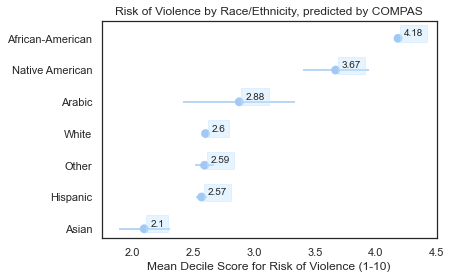

In [12]:
# set theme and color palette
sns.set_theme(style="white")
sns.set_palette('pastel', n_colors = len(result_frame))

# create plot
# set figure size and set padding around subplots to "tight" 
# (to make sure labs are included)
# plt.figure(figsize=[6, 5])
plt.tight_layout()
ax = sns.pointplot(y = "race_ethnicity", 
                x= "mean", 
                orient = "h",
                data = result_frame,
                join = False)
# add error bars      
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax.errorbar(x = x_coords, y = y_coords, xerr = result_frame.mean_se, 
            fmt=' ')
# create updated ylim (from current limit)
ylim = list(ax.get_ylim())
ylim[1] -= 0.25
# set labels
ax.set(xlabel = "Mean Decile Score for Risk of Violence (1-10)",
        ylabel = "",
        xlim = (1.75,4.5),
        ylim = ylim,
        title = "Risk of Violence by Race/Ethnicity, predicted by COMPAS")
# add annotations
for i, mean_label in enumerate(result_frame['mean']):
    t = ax.annotate(round(mean_label, 2), (x_coords[i]+0.05, y_coords[i]-0.075), fontsize = "small")
    t.set_bbox(dict(facecolor='#C0E4FF', alpha=0.4, edgecolor = '#C0E4FF'))

# save figure
plt.savefig("risk_of_violence_race.png", bbox_inches = "tight")

Observationally, we can see that on average, COMPAS predicted the highest Risk of Violence decile score for African-American criminal defendants, followed by Native Americans. The bars surrounding the points show the standard error for that calculation. We can see that the standard error for the African American predictions is very very small, which indicates that the average score predicted is a fairly accurate reflection of scores within that group. Alternatively, the standard error for Arabic defendants is much larger (though still, given the range of scores is 1-10, fairly small), which could indicate a higher variability in estimates compared to the other groups if we calculated the average score for that group an infinite number of times. Further analysis using summary statistics, etc, would need to be completed in order to fully evaluate bias in risk of violence score estimates by COMPAS to determine statistical significance, but these observational results do not appear to refute the assumption that the scores are potentially biased.